Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

*Загрузим необходимые библиотеки*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import string
import re
import warnings
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DruzykRB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DruzykRB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DruzykRB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
toxic_comments_df = pd.read_csv(r'C:\datasets\Практикум\Project\toxic_comments.csv')

*Посмотрим на наши данные*

In [3]:
print("Размер датасета:", toxic_comments_df.shape)
toxic_comments_df.head()

Размер датасета: (159571, 2)


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


*Посмотрим на балан/дисбаланс классов в целевой переменной*

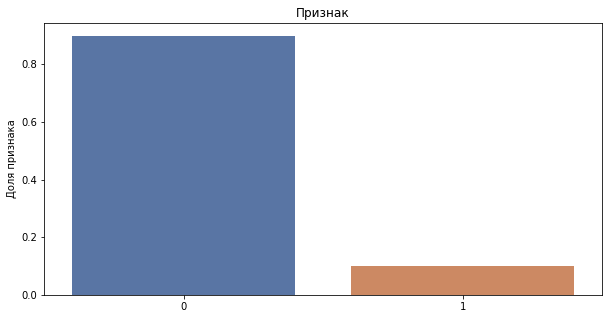

In [4]:
fig, axes = plt.subplots(1, figsize=(10, 5))
sns.barplot(x=toxic_comments_df.toxic.value_counts(normalize=True).index, 
            y=toxic_comments_df.toxic.value_counts(normalize=True).values, 
            palette="deep")
plt.ylabel('Доля признака')
plt.title('Признак')
plt.show()

*У нас явный дисбаланс классов, что объяснимо, токсичных комментариев на порядок меньше. Учтем этот момент и обработаем его позже*

***

*Для лучшей обработки текста, удалим из текста знаки пунктуации и стоп-слова и лемматезируем текст*

In [5]:
text_string = toxic_comments_df.iloc[37]['text']
text_string

"pretty much everyone from warren county/surrounding regions was born at glens falls hospital. myself included. however, i'm not sure this qualifies anyone as being a glens falls native. rachel ray is, i believe, actually from the town of lake luzerne.  —The preceding unsigned comment was added by 70.100.229.154  04:28:57, August 19, 2007 (UTC)"

In [6]:
def lemmatize(text):
    text = text.lower().replace("\n", "") #Приведем к нижнему регистру
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') #подготовим паттерн удаления стоп-слов
    text = pattern.sub('', text) #Применим патерн
    text = re.sub(r'[^a-z]', r' ', text.strip()) #Удалим все не буквы
    result = str()
    for word in nltk.tokenize.word_tokenize(text):
        result += WordNetLemmatizer().lemmatize(word) + ' '
    result = " ".join(result.split())
    return result

In [7]:
toxic_comments_df['text'] = toxic_comments_df['text'].apply(lemmatize)

In [8]:
text_string = toxic_comments_df.iloc[37]['text']
text_string

'pretty much everyone warren county surrounding region born glen fall hospital included however sure qualifies anyone glen fall native rachel ray believe actually town lake luzerne preceding unsigned comment added august utc'

*Текст очищет и лемматезирован. Можно приступать к формированию мешка слов*

***

*Создадим мешок слов, а так же сразу выделим целевую переменную*

In [15]:
X = toxic_comments_df['text']
y = toxic_comments_df['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [16]:
vectorizer = TfidfVectorizer(min_df=20, analyzer='word')
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [17]:
print("Размер мешка слов обучающися:", X_train.shape)
print("Размер мешка слов тестовый:", X_test.shape)

Размер мешка слов обучающися: (119678, 10675)
Размер мешка слов тестовый: (39893, 10675)


***

# 2. Обучение

*Перед нами стоит задача классификации*

*Так как в наших данных много признаков, а мы знаем, что ансамбль деревьев медленно работает с большим количеством признаков - не будем его использовать.*

*Проверим следующие модели:*
 * *LogisticRegression*
 * *LGBMClassifier*
 * *LinearSVC*
 * *RidgeClassifier*

*Создадим первоначальный Pipeline*

In [18]:
pipe = Pipeline([('classifier', LGBMClassifier())])

*Теперь зададим сетку параметров для поиска*

In [26]:
param_grid = [
    {'classifier': [LogisticRegression()], 
     'classifier__C': [0.1, 1, 10], 
     'classifier__solver': ['lbfgs', 'liblinear']}, 
    {'classifier': [LinearSVC()], 
     'classifier__C': [0.1, 1, 10]}, 
    {'classifier': [RidgeClassifier()], 
     'classifier__solver': ['sag', 'sparse_cg'], 
     'classifier__alpha': [0.1, 1, 10]}, 
    {'classifier': [LGBMClassifier()],
     'classifier__learning_rate': [0.2, 0.25],  
     'classifier__n_estimators': [150, 200]} 
]

<font color='blue'>Параметр C лучше перебирать по степеням: $10^{-5}, 10^{-4}, \dots 10^{5}$, например. </font>


In [27]:
skf = StratifiedKFold(n_splits=3)
grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='f1')
grid.fit(X_train, y_train);

*Посмотрим, какая модель и с какими параметрами оказалась лучшей:*

In [28]:
grid.best_params_['classifier']

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

*В нашем случае лучшим оказался линейный метод опорных векторов*

***

In [29]:
predict_linearSVC = grid.predict(X_test)
print('Значение F1-меры на тестовой выборке: {:.2f}'.format(f1_score(y_test, predict_linearSVC)))

Значение F1-меры на тестовой выборке: 0.78


# 3. Выводы

*У нас получилось предобработать массив текстовых данных, создать мешок слов, очишенный от стоп-слов, знаков пункутации и цифр. На наших данных лучшей оказалась модель, основанная на линейном методе опорных векторов. Соизмеримым с данным методом так же был и LightGBM, но скорость обучения у градиентного бустинка гораздо выше. Качество работы модели мы оценили на F1-мере и она оказалась на тестовой выборке выше 0.75*